In [4]:
# Import necessary libraries
import torch
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# Captum imports
from captum.attr import GradientShap, IntegratedGradients, Saliency, DeepLift
from captum.attr import visualization as viz

# Hugging Face and data loading
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from huggingface_hub import hf_hub_download

# Local imports
from ecallisto_dataset import (
    EcallistoDatasetBinary,
    custom_resize,
    remove_background,
    normal_resize,
)
from ecallisto_model import GrayScaleResNet
from pred_live import load_model, prepare_ecallisto_datasets, prepare_dataloaders

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Configuration and Model Loading

In [5]:
# Model and configuration parameters
REPO_ID = "i4ds/flaresense-v2"
MODEL_FILENAME = "model.ckpt"
CONFIG_PATH = "configs/best_v2.yml"

# Download model checkpoint
checkpoint_path = hf_hub_download(repo_id=REPO_ID, filename=MODEL_FILENAME)

# Load model and configuration
model, config = load_model(checkpoint_path, CONFIG_PATH)
model = model.to(device)
model.eval()

print("Model loaded successfully!")
print(f"Model type: {config['model']['model_type']}")
print(f"Input size: {config['model']['input_size']}")

Model loaded successfully!
Model type: resnet34
Input size: [128, 512]


## Load Test Dataset

In [6]:
# Load test dataset
ds = load_dataset(
    config["data"]["pred_path"],
    split=config["data"]["pred_split"],  # Use test split
    cache_dir="/mnt/nas05/data01/vincenzo/hu",
)

print(f"Dataset loaded: {len(ds)} samples")
print(f"Dataset columns: {ds.column_names}")

# Prepare ecallisto dataset and dataloader
edb = prepare_ecallisto_datasets(ds, config)
dataloader = prepare_dataloaders(edb, config["general"]["batch_size"])

print(f"Dataloader created with batch size: {config['general']['batch_size']}")

Dataset loaded: 30549 samples
Dataset columns: ['image', 'manual_label', 'logits', 'prob', 'model_label', 'start_datetime', 'antenna']
Dataloader created with batch size: 64


## Create Model Wrapper for Captum

Captum requires the model to output class probabilities. We'll create a wrapper that:
1. Takes the model's output logits
2. Applies sigmoid to get probabilities (for binary classification)
3. Returns probabilities for both classes (no burst, burst)

In [7]:
class ModelWrapper(torch.nn.Module):
    """Wrapper for the model to output probabilities for both classes."""
    
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        # Get logits from model (shape: [batch_size, 1])
        logits = self.model(x)
        
        # Apply sigmoid to get probability of positive class
        prob_positive = torch.sigmoid(logits)
        
        # Create probabilities for both classes [no_burst, burst]
        prob_negative = 1 - prob_positive
        
        # Return as [batch_size, 2] tensor
        return torch.cat([prob_negative, prob_positive], dim=1)

# Create wrapped model
wrapped_model = ModelWrapper(model)
wrapped_model.eval()

print("Model wrapper created successfully!")

Model wrapper created successfully!


## Initialize Captum Attribution Methods

We'll use several attribution methods:
- **GradientShap**: Uses gradient information and random baselines
- **IntegratedGradients**: Integrates gradients along a path from baseline to input
- **Saliency**: Simple gradient-based attribution
- **DeepLift**: Compares activation of neurons to reference activation

In [8]:
# Initialize attribution methods
gradient_shap = GradientShap(wrapped_model)
integrated_gradients = IntegratedGradients(wrapped_model)
saliency = Saliency(wrapped_model)
deep_lift = DeepLift(wrapped_model)

print("Attribution methods initialized:")
print("- GradientShap")
print("- IntegratedGradients")
print("- Saliency")
print("- DeepLift")

Attribution methods initialized:
- GradientShap
- IntegratedGradients
- Saliency
- DeepLift


## Function to Compute Attributions with GradientShap

This function follows the Captum example for GradientShap, which uses random baselines.

In [9]:
def compute_gradient_shap_attributions(inputs, labels, n_baselines=20, target_class=1):
    """
    Compute GradientShap attributions for a batch of inputs.
    
    Args:
        inputs: Input tensor [batch_size, channels, height, width]
        labels: Ground truth labels [batch_size]
        n_baselines: Number of random baselines to use
        target_class: Target class for attribution (0=no_burst, 1=burst)
    
    Returns:
        attributions: Attribution tensor same shape as inputs
    """
    batch_size = inputs.shape[0]
    channels, height, width = inputs.shape[1:]
    
    # Create random baselines - shape: [n_baselines, channels, height, width]
    # Using random noise similar to the input distribution
    baselines = torch.randn(n_baselines, channels, height, width).to(inputs.device)
    
    # Compute attributions for the target class
    attributions = gradient_shap.attribute(
        inputs,
        baselines=baselines,
        target=target_class,
        n_samples=10  # Number of samples for approximating Shapley values
    )
    
    return attributions


def compute_other_attributions(inputs, method_name, target_class=1):
    """
    Compute attributions using other methods.
    
    Args:
        inputs: Input tensor [batch_size, channels, height, width]
        method_name: 'integrated_gradients', 'saliency', or 'deep_lift'
        target_class: Target class for attribution (0=no_burst, 1=burst)
    
    Returns:
        attributions: Attribution tensor same shape as inputs
    """
    if method_name == 'integrated_gradients':
        # Use zero baseline
        baseline = torch.zeros_like(inputs)
        attributions = integrated_gradients.attribute(
            inputs,
            baselines=baseline,
            target=target_class
        )
    elif method_name == 'saliency':
        attributions = saliency.attribute(inputs, target=target_class)
    elif method_name == 'deep_lift':
        baseline = torch.zeros_like(inputs)
        attributions = deep_lift.attribute(
            inputs,
            baselines=baseline,
            target=target_class
        )
    else:
        raise ValueError(f"Unknown method: {method_name}")
    
    return attributions

print("Attribution functions defined!")

Attribution functions defined!


## Interactive Visualization - Change `idx` to view different samples

Just change the `idx` value and re-run the cell to see different images!

In [16]:
sample

(tensor([[[0.9481, 0.9854, 0.3802,  ..., 0.7504, 0.8137, 0.8734],
          [0.0789, 0.0718, 0.0727,  ..., 0.0748, 0.0685, 0.0689],
          [0.1102, 0.1040, 0.1070,  ..., 0.0669, 0.0786, 0.0882],
          ...,
          [0.0965, 0.1013, 0.0991,  ..., 0.1056, 0.1046, 0.1041],
          [0.0969, 0.0970, 0.0938,  ..., 0.1030, 0.1028, 0.0962],
          [0.0972, 0.0951, 0.0947,  ..., 0.1009, 0.0985, 0.0924]]]),
 tensor([0.]),
 'ALASKA-COHOE_63',
 '2023-02-27 18:46:00')

In [ ]:
from ecallisto

Image tensor saved as PNG for index 0


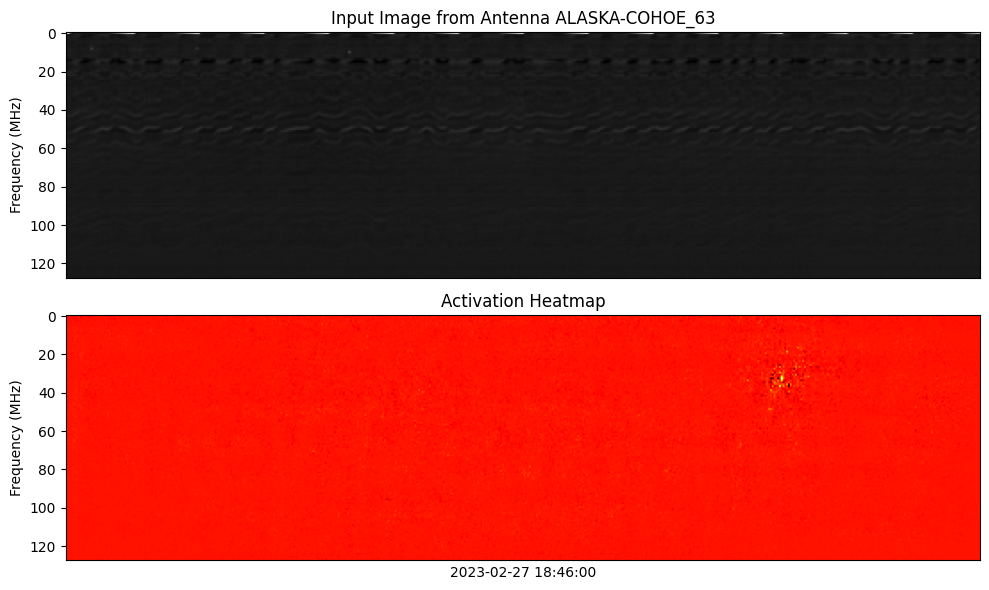


Sample 0/30548 | Prediction: 0.122 | True Label: 0.0


In [15]:
# ============= CHANGE THIS INDEX TO VIEW DIFFERENT SAMPLES =============
idx = 0
# =======================================================================

# Get sample from dataset
sample = edb[idx]
input_image = sample[0].unsqueeze(0).to(device)
true_label = sample[1].item()
antenna_name = sample[2]
datetime_str = sample[3]

input_image.requires_grad = True

# Get prediction
output = wrapped_model(input_image)
pred_prob = output[0, 1].item()

# Compute GradientShap attribution
baselines = torch.randn(20, *input_image.shape[1:]).to(device)
attribution = gradient_shap.attribute(input_image, baselines=baselines, target=1, n_samples=10)

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Top: Original image
img = input_image[0].cpu().detach()
if img.shape[0] == 1:
    ax1.imshow(img.squeeze(0), cmap='gray', aspect='auto')
else:
    ax1.imshow(img.permute(1, 2, 0), aspect='auto')
ax1.set_title(f'Input Image from Antenna {antenna_name}')
ax1.set_ylabel('Frequency (MHz)')
ax1.set_xticks([])

# Bottom: XAI heatmap
attr = attribution[0].cpu().detach()
if attr.shape[0] == 1:
    attr_display = attr.squeeze(0).numpy()
else:
    attr_display = attr.sum(0).numpy()

ax2.imshow(attr_display, cmap='hot', aspect='auto')
ax2.set_title('Activation Heatmap')
ax2.set_ylabel('Frequency (MHz)')
ax2.set_xlabel(f'{datetime_str}')
ax2.set_xticks([])

plt.tight_layout()
plt.show()

print(f"\nSample {idx}/{len(edb)-1} | Prediction: {pred_prob:.3f} | True Label: {true_label}")